In [1]:
import os
import numpy as np
import glob
import pandas as pd
import geopandas as gpd
from argparse import Namespace
import matplotlib.pyplot as plt
import shapely
import shapely.geometry
from descartes import PolygonPatch

from maskrcnn.postprocess.resample import Resampler

In [2]:
# AOI index data w/ georeferencing info
AOI_IN_DIR = 'data/Experiment4/aoi.csv'
# download log data
LOG_IN_DIR = 'data/Experiment4/aoi_download_log.csv'

# satellite derived data
SAT_IN_GEOM_DIR = 'data/Experiment4/sat.geojson'

SAMPLE_SHP_IN_DIR = 'data/Shapefile/GDFigure2/SampleArea.shp'

OUT_DIR = 'data/Experiment4/output/'

In [3]:
cmap = plt.get_cmap('coolwarm', 8)

## Plotting Raster

In [4]:
min_lon = 34.040  # 34.044261
max_lon = 34.460  # 34.451611
min_lat = -0.055  # -0.050481
max_lat = 0.315  # 0.310766
step = 0.002

In [5]:
df = gpd.read_file(SAT_IN_GEOM_DIR)

In [6]:
df.columns

Index(['angle', 'xmin', 'ymin', 'width', 'height', 'R_mean', 'G_mean',
       'B_mean', 'R_median', 'G_median', 'B_median', 'redness', 'luminosity',
       'saturation', 'area', 'score', 'index', 'category_id', 'geometry'],
      dtype='object')

In [7]:
df.shape

(355777, 19)

In [8]:
df.loc[:, 'centroid_lon'] = df.geometry.centroid.x.values
df.loc[:, 'centroid_lat'] = df.geometry.centroid.y.values

# snap to grid
df.loc[:, 'grid_lon'] = np.round((df['centroid_lon'].values - min_lon) / step).astype(np.int32)
df.loc[:, 'grid_lat'] = np.round((df['centroid_lat'].values - min_lat) / step).astype(np.int32)

In [9]:
df_group = df.groupby(['grid_lon', 'grid_lat']).agg(
    house_count=pd.NamedAgg(column='area', aggfunc='count'),
    house_area_mean=pd.NamedAgg(column='area', aggfunc='mean'),
    area_sum=pd.NamedAgg(column='area', aggfunc='sum'),
)

grid_lon, grid_lat = np.meshgrid(
    np.arange(0, np.round((max_lon - min_lon) / step).astype(np.int32) + 1),
    np.arange(0, np.round((max_lat - min_lat) / step).astype(np.int32) + 1))
grid_shape = grid_lon.shape

df_grid = pd.DataFrame({'grid_lon': grid_lon.flatten(), 'grid_lat': grid_lat.flatten()})

df_grid = pd.merge(df_grid, df_group, how='left', on=['grid_lon', 'grid_lat'])

df_grid.fillna(0, inplace=True)

In [10]:
bound, = gpd.read_file(SAMPLE_SHP_IN_DIR)['geometry']
outside = shapely.geometry.box(min_lon, min_lat, max_lon, max_lat).difference(bound)

In [11]:
raster = df_grid['area_sum'].values.reshape(grid_shape)[::-1, :]

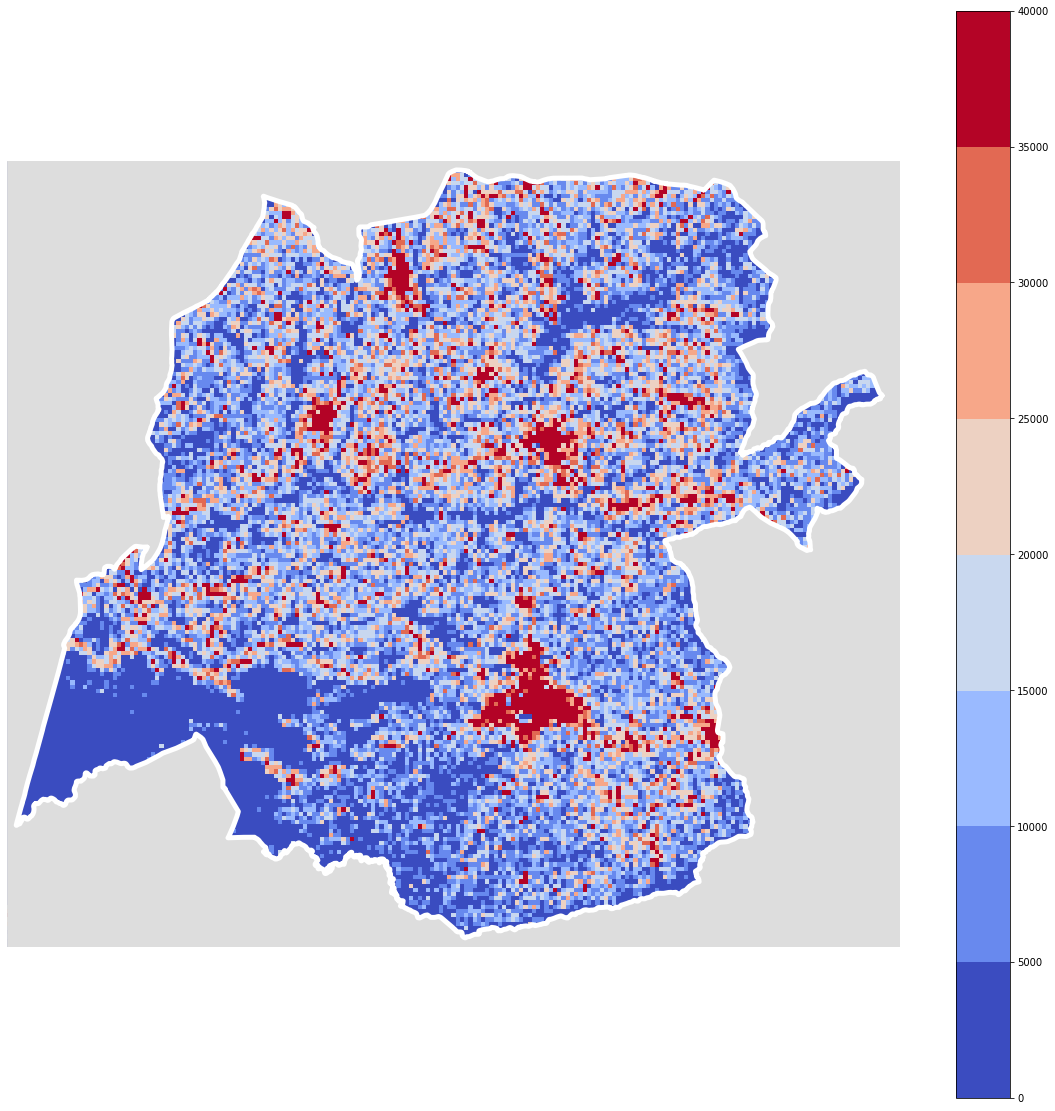

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(raster,
               extent=(min_lon, max_lon, min_lat, max_lat),
               cmap=cmap, vmax=4e4)
ax.plot(*bound.exterior.xy, color='white', linewidth=5)
ax.add_patch(PolygonPatch(outside, facecolor='#dddddd', edgecolor='#dddddd'))
ax.axis('off')
fig.colorbar(im)
fig.savefig(os.path.join(OUT_DIR, 'building_footprint.pdf'))

## Plotting Images and Annotations

In [13]:
# read image index data frame
df = pd.merge(pd.read_csv(AOI_IN_DIR),
              pd.read_csv(LOG_IN_DIR).loc[:, 'index'],
              how='right', on='index')

In [14]:
# set up visualization cfg
cfg = Namespace()
cfg.visual_score_cutoff = 0.9
cfg.xmax = 480
cfg.ymax = 770
cfg.up_scale = 1
cfg.font = 'maskrcnn/utils/fonts/UbuntuMono-B.ttf'
cfg.font_size = 40
cfg.bbox_outline = [255, 255, 255, 255]  # white
cfg.bbox_width = 6  # in pixels
cfg.label_fill = [255, 255, 255, 255]
cfg.category_palette = {
    1: [150, 223, 228, 64],  # blue
    2: [223, 150, 228, 64],
    3: [228, 223, 150, 64],
}
cfg.int_dict = {
    1: 'thatched roof',
    2: 'metal roof',
    3: 'colored roof',
}

In [15]:
# link all inference data
r = Resampler.from_bounds(
    img_dir=SAT_IN_IMG_DIR,
    ann_dir=SAT_IN_ANN_DIR,
    indices=df['index'].values.tolist(),
    bounds=df[['lon_min', 'lat_min', 'lon_max', 'lat_max']].values.tolist())

NameError: name 'SAT_IN_IMG_DIR' is not defined

In [ ]:
bounds = (34.2812, 0.059, 34.2837, 0.0615)
r.plot(bounds=bounds, width=5000, height=5000, mode='img')
r.output

In [ ]:
lon_min = np.random.uniform(34.044261, 34.451611)
lat_min = np.random.uniform(-0.050481, 0.310766)
bounds = (lon_min, lat_min, lon_min + 0.0025, lat_min + 0.0025)

In [ ]:
r.plot(bounds=bounds, width=3000, height=3000, mode='ann', cfg=cfg)
r.output